In [47]:
from configobj import ConfigObj
import subprocess
import os, sys
import math
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Markdown
from astropy.table import Table, Column
from astropy.io import ascii
from astropy.coordinates import SkyCoord,Angle
from astropy.time import Time
from astroplan import Observer
from Atmospheric_diffraction import *
%matplotlib inline 
import math
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as mpl
plt.style.use('bmh')
import Transmission_calculation as trans_calc

import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.modeling.functional_models import Disk2D
from astropy.modeling.models import Gaussian2D
from astropy.modeling.models import Moffat2D

import time

In [48]:
def numerical_gaussian(fibre_diameter,FWHM,offset,scale):
    std = FWHM.value/(2*np.sqrt(2*np.log(2)))/scale
    x_pos=offset/scale

    gaussian_total= 2*np.pi*std**2 

    b2=math.ceil(fibre_diameter.value/2/scale)

    x = np.arange(-b2, b2+1)
    y = np.arange(-b2, b2+1)
    x, y = np.meshgrid(x, y)

    Disk=Disk2D(1,0,0,fibre_diameter.value/2/scale)
    Disk_data=Disk(x,y)
    Gaussian=Gaussian2D(1,x_pos.value,0,std,std)
    Gaussian_data=Gaussian(x,y)
    profile_data=Gaussian_data[int(len(Gaussian_data)/2)]

    convolved_data=Disk_data*Gaussian_data

    # fig, ax = plt.subplots()
    # ax.imshow(Disk_data)
    # fig, ax = plt.subplots()
    # ax.imshow(Gaussian_data)
    # fig, ax = plt.subplots()
    # ax.imshow(convolved_data)

    trans=sum(sum(convolved_data))/gaussian_total
    return trans, profile_data

def numerical_moffat(fibre_diameter,FWHM,offset,scale,beta=2.5):
    alpha=FWHM.value/scale/(2*np.sqrt(2**(1/beta)-1))

    moffat_total=(np.pi*alpha**2)/(beta-1)

    x_pos=offset/scale  

    b2=math.ceil(fibre_diameter.value/2/scale)

    x = np.arange(-b2, b2+1)
    y = np.arange(-b2, b2+1)
    x, y = np.meshgrid(x, y)

    Disk=Disk2D(1,0,0,fibre_diameter.value/2/scale)
    Disk_data=Disk(x,y)
    Moffat=Moffat2D(1,x_pos.value,0,alpha,beta)
    Moffat_data=Moffat(x,y)
    profile_data=Moffat_data[int(len(Moffat_data)/2)]

    convolved_data=Disk_data*Moffat_data

    # fig, ax = plt.subplots()
    # ax.imshow(Disk_data)
    # fig, ax = plt.subplots()
    # ax.imshow(Moffat_data)
    # fig, ax = plt.subplots()
    # ax.imshow(convolved_data)

    trans=sum(sum(convolved_data))/moffat_total
    return trans, profile_data

def analytical_gaussian(fibre_diameter,FWHMs,shifts,k_lim):
    """
    Calculates transmission of Gaussian PSF offset from a circular aperture
    See https://opg.optica.org/ao/fulltext.cfm?uri=ao-58-4-1048&id=404390
    Analytical solution featuring infinite sum

    INPUTS:
    fibre_diameter: float, arcsec astropy units
        diameter of the fibre/aperture
    FWHMs: array, astropy units
        array of FWHMs
    shifts: array, astropy units
        array of shifts
    k_lim: float
        term to carry out the infinite sum too; rapidly converges within typically ~20 terms

    OUTPUTS:
    Returns:
    transmission: array
        array of transmissions
    """
    fibre_radius=fibre_diameter.value/2
    offset=shifts.value
    FWHMs=FWHMs.value

    prefactor=np.exp(-4*np.log(2)*offset**2/FWHMs**2)
    k_sum=0
    for k in range(0,k_lim):
        i_sum=0
        for i in range(0,k+1):
            i_sum=i_sum+(2**i*fibre_radius**(2*i)/math.factorial(i))*(2*np.log(2)/FWHMs**2)**i
        k_sum=k_sum+2**k*offset**(2*k)/math.factorial(k)*(2*np.log(2)/FWHMs**2)**k*(1-np.exp(-4*np.log(2)*fibre_radius**2/FWHMs**2)*i_sum)
    transmission=prefactor*k_sum
    return transmission


(0.0, 1.1)

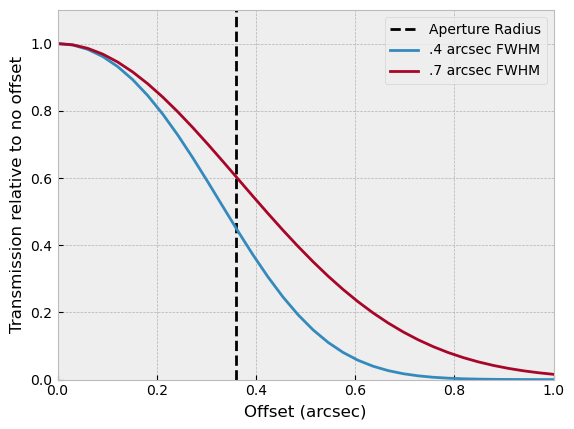

In [49]:
plt.axvline(0.72/2,label="Aperture Radius",color='black',linestyle='--')
transes=[]
offsets=np.linspace(0,3,100)*u.arcsec
for offset in offsets:
    trans=analytical_gaussian(.72*u.arcsec,.4*u.arcsec,offset,50)
    transes.append(trans)
plt.plot(offsets,transes/transes[0],label=".4 arcsec FWHM")
transes=[]
for offset in offsets:
    trans=analytical_gaussian(.72*u.arcsec,.7*u.arcsec,offset,50)
    transes.append(trans)
plt.plot(offsets,transes/transes[0],label=".7 arcsec FWHM")

plt.legend()
plt.xlabel("Offset (arcsec)")
plt.ylabel("Transmission relative to no offset")
plt.xlim(0,1)
plt.ylim(0,1.1)

(0.0, 1.1)

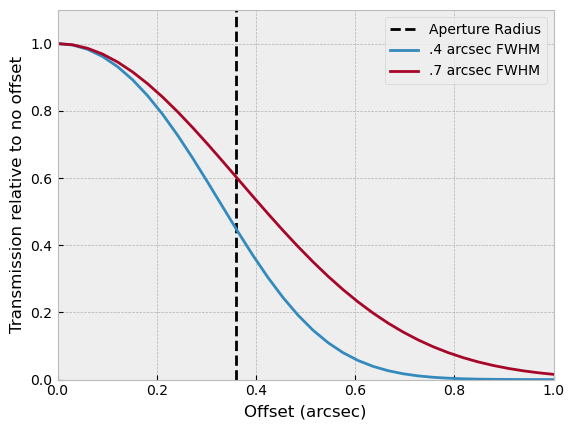

In [50]:
plt.axvline(0.72/2,label="Aperture Radius",color='black',linestyle='--')
transes=[]
offsets=np.linspace(0,3,100)*u.arcsec
for offset in offsets:
    trans,profile=numerical_gaussian(.72*u.arcsec,.4*u.arcsec,offset,0.01)
    transes.append(trans)
plt.plot(offsets,transes/transes[0],label=".4 arcsec FWHM")
transes=[]
for offset in offsets:
    trans,profile=numerical_gaussian(.72*u.arcsec,.7*u.arcsec,offset,0.01)
    transes.append(trans)
plt.plot(offsets,transes/transes[0],label=".7 arcsec FWHM")

plt.legend()
plt.xlabel("Offset (arcsec)")
plt.ylabel("Transmission relative to no offset")
plt.xlim(0,1)
plt.ylim(0,1.1)

(0.0, 1.1)

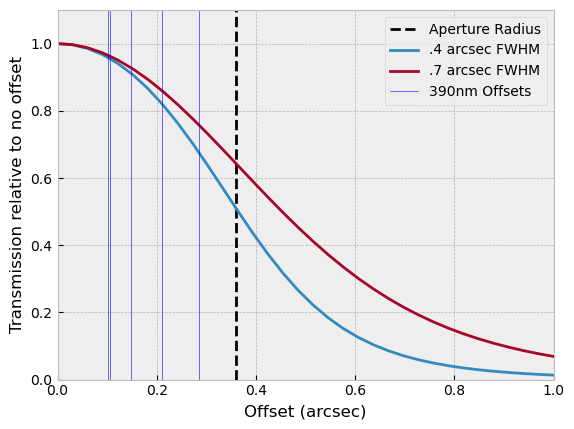

In [59]:
plt.axvline(0.72/2,label="Aperture Radius",color='black',linestyle='--')
transes=[]
offsets=np.linspace(0,3,100)*u.arcsec
for offset in offsets:
    trans,profile=numerical_moffat(.72*u.arcsec,.4*u.arcsec,offset,0.01)
    transes.append(trans)
plt.plot(offsets,transes/transes[0],label=".4 arcsec FWHM")
transes=[]
for offset in offsets:
    trans,profile=numerical_moffat(.72*u.arcsec,.7*u.arcsec,offset,0.01)
    transes.append(trans)
plt.plot(offsets,transes/transes[0],label=".7 arcsec FWHM")
shifts=[-0.10200429,-0.10503837,-0.14753776,-0.21069023,-0.28538719]*u.arcsec
for shift in shifts:
    plt.axvline(abs(shift.value),linewidth=0.4,color='blue')
plt.axvline(abs(0),linewidth=0.4,color='blue',label="390nm Offsets")
plt.legend()
plt.xlabel("Offset (arcsec)")
plt.ylabel("Transmission relative to no offset")
plt.xlim(0,1)
plt.ylim(0,1.1)

In [55]:
shifts=[-0.10200429,-0.10503837,-0.14753776,-0.21069023,-0.28538719]*u.arcsec
transes=[]
for offset in shifts:
    trans,profile=numerical_moffat(.72*u.arcsec,.4*u.arcsec,offset,0.01)
    transes.append(trans)
trans_opt,profile=numerical_moffat(.72*u.arcsec,.4*u.arcsec,0*u.arcsec,0.01)
print(transes/trans_opt)
print(np.mean(transes/trans_opt))


transes=[]
for offset in shifts:
    trans,profile=numerical_moffat(.72*u.arcsec,.7*u.arcsec,offset,0.01)
    transes.append(trans)
trans_opt,profile=numerical_moffat(.72*u.arcsec,.7*u.arcsec,0*u.arcsec,0.01)
print(transes/trans_opt)
print(np.mean(transes/trans_opt))

[0.95848375 0.9559566  0.91252468 0.8205768  0.67516782]
0.8645419295657544
[0.96536938 0.96331326 0.92878755 0.85976404 0.75737236]
0.8949213178433579


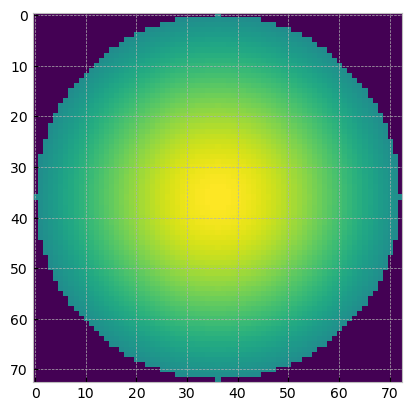

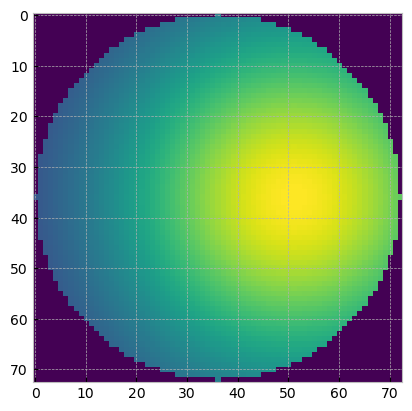

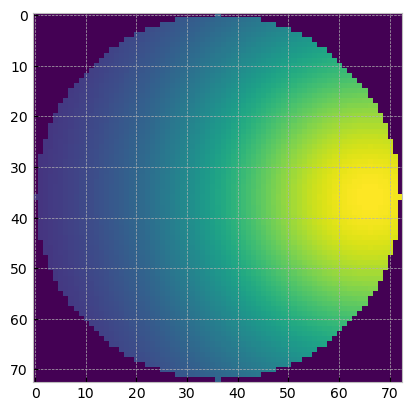

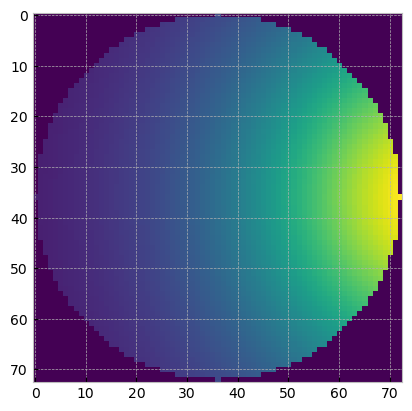

In [45]:
def numerical_moffat(fibre_diameter,FWHM,offset,scale,beta=2.5):
    alpha=FWHM.value/scale/(2*np.sqrt(2**(1/beta)-1))

    moffat_total=(np.pi*alpha**2)/(beta-1)

    x_pos=offset/scale  

    b2=math.ceil(fibre_diameter.value/2/scale)

    x = np.arange(-b2, b2+1)
    y = np.arange(-b2, b2+1)
    x, y = np.meshgrid(x, y)

    Disk=Disk2D(1,0,0,fibre_diameter.value/2/scale)
    Disk_data=Disk(x,y)
    Moffat=Moffat2D(1,x_pos.value,0,alpha,beta)
    Moffat_data=Moffat(x,y)
    profile_data=Moffat_data[int(len(Moffat_data)/2)]

    convolved_data=Disk_data*Moffat_data


    fig, ax = plt.subplots()
    ax.imshow(convolved_data)

    trans=sum(sum(convolved_data))/moffat_total
    return trans, profile_data

shifts=[0,0.15,0.3,0.45]*u.arcsec
transes=[]
for offset in shifts:
    trans,profile=numerical_moffat(.72*u.arcsec,.7*u.arcsec,offset,0.01)
    transes.append(trans)
